# INIZIALIZZAZIONE

In [1]:
# importo le librerie
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm

from IPython.display import display, Markdown

import requests
from bs4 import BeautifulSoup
import os 
from dotenv import load_dotenv 

import sqlite3

In [2]:
#carico il dataset
file_path=r"C:\Documenti\Lavoro\Progetti Data Analyst\archive\Train-Set.csv"
df=pd.read_csv(file_path)

In [3]:
#verifico il dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductID          8523 non-null   object 
 1   Weight             7060 non-null   float64
 2   FatContent         8523 non-null   object 
 3   ProductVisibility  8523 non-null   float64
 4   ProductType        8523 non-null   object 
 5   MRP                8523 non-null   float64
 6   OutletID           8523 non-null   object 
 7   EstablishmentYear  8523 non-null   int64  
 8   OutletSize         6113 non-null   object 
 9   LocationType       8523 non-null   object 
 10  OutletType         8523 non-null   object 
 11  OutletSales        8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df.shape

(8523, 12)

# DATA CLEANING

## Missing value "Weight"

In [6]:
#la colonna "weight" ha dei missing value che vanno gestiti
#verifico se esistono prodotti con più pesi diversi
df.groupby('ProductID')['Weight'].nunique().sort_values(ascending=False).head()

ProductID
NCZ54    1
DRA12    1
DRA24    1
DRA59    1
DRB01    1
Name: Weight, dtype: int64

In [7]:
# imputo i valori mancanti assumendo il peso come proprietà del prodotto
df['Weight'] = df.groupby('ProductID')['Weight'].transform(lambda x: x.fillna(x.median()))

In [8]:
df['Weight'].isna().sum()

np.int64(4)

In [9]:
#rimangono solo 4/8523 entry senza peso, assumo per loro il peso medio di categoria
df['Weight'] = df['Weight'].fillna(df.groupby('ProductType')['Weight'].transform('mean'))

In [10]:
df['Weight'].isna().sum()

np.int64(0)

## Missing Value "OutletSize"

In [11]:
# Filtra tra le righe gli OutletID unici con OutletSize nullo
unique_null_outlets = df[df['OutletSize'].isnull()]['OutletID'].unique()

print("OutletID unici con OutletSize nullo:")
print(unique_null_outlets)

OutletID unici con OutletSize nullo:
['OUT010' 'OUT045' 'OUT017']


In [12]:
# Conteggio dei valori per categoria di OutletSize
outletsize_counts = df['OutletSize'].value_counts(dropna=False)  # dropna=False include i NaN
print("Conteggio degli OutletSize per categoria:")
print(outletsize_counts)

Conteggio degli OutletSize per categoria:
OutletSize
Medium    2793
NaN       2410
Small     2388
High       932
Name: count, dtype: int64


In [13]:
# Conteggio degli outlet unici per categoria di OutletSize
outlet_per_size = df.groupby('OutletSize')['OutletID'].nunique()

print("Numero di OutletID unici per categoria di OutletSize:")
print(outlet_per_size)

Numero di OutletID unici per categoria di OutletSize:
OutletSize
High      1
Medium    3
Small     3
Name: OutletID, dtype: int64


In [14]:
# Conteggio delle righe per ciascun OutletID
rows_per_outlet = df['OutletID'].value_counts()

print("Numero di righe per ciascun OutletID:")
print(rows_per_outlet)

Numero di righe per ciascun OutletID:
OutletID
OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64


In [15]:
#non ho un ragionamento forte dietro questa decisione ma per motivi di analisi assegno due outletID tra i NaN alla categoria Small e uno a Medium
# Assegna la categoria 'Small' a OUT010 e OUT017
df.loc[df['OutletID'].isin(['OUT010', 'OUT017']), 'OutletSize'] = 'Small'

# Assegna la categoria 'Medium' a OUT045
df.loc[df['OutletID'] == 'OUT045', 'OutletSize'] = 'Medium'

# Verifica il risultato
outlet_per_size = df.groupby('OutletSize')['OutletID'].nunique()
print(outlet_per_size)

OutletSize
High      1
Medium    4
Small     5
Name: OutletID, dtype: int64


## Categorizzazione "FatContent"

In [16]:
df["FatContent"].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [17]:
# aggrego 'Low Fat', 'low fat', 'LF' in una categoria e 'Regular' e 'reg' in un'altra
fat_mapping = {
    'Low Fat': 'Low Fat',
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'Regular': 'Regular',
    'reg': 'Regular'}

# Applica la mappatura alla colonna FatContent
df['FatContent'] = df['FatContent'].replace(fat_mapping)

# Verifica il risultato
print(df['FatContent'].value_counts())

FatContent
Low Fat    5517
Regular    3006
Name: count, dtype: int64


## Approccio alla "ProductVisibility"=0

<Axes: >

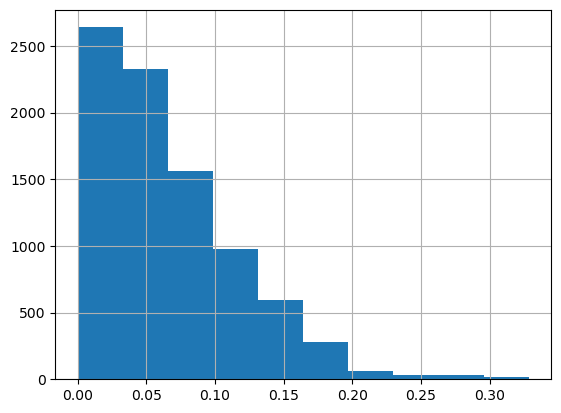

In [18]:
# ricerca di un metodo per gestire i prodotti con visibilità pari a 0
df["ProductVisibility"].hist()

In [19]:
# Filtro le righe con visibilità 0
zero_vis_rows = df[df['ProductVisibility'] == 0]

# Conto quanti ProductID unici ci sono in queste righe
unique_zeros = zero_vis_rows['ProductID'].nunique()

print(f"Righe totali con 0: {len(zero_vis_rows)}")      
print(f"Prodotti unici con 0: {unique_zeros}")           

Righe totali con 0: 526
Prodotti unici con 0: 446


In [20]:
# verifico la correlazione tra le colonne numeriche
# in caso di forte correlazione posso assumere una dipendenza 
# ed avere delle basi per assegnare dei valori ai prodotti con visibilià 0
numerical_columns = ['Weight', 'ProductVisibility', 'MRP', 'EstablishmentYear', 'OutletSales']
correlation_matrix = df[numerical_columns].corr()
print(correlation_matrix)

                     Weight  ProductVisibility       MRP  EstablishmentYear  \
Weight             1.000000          -0.009215  0.025967          -0.013417   
ProductVisibility -0.009215           1.000000 -0.001315          -0.074834   
MRP                0.025967          -0.001315  1.000000           0.005020   
EstablishmentYear -0.013417          -0.074834  0.005020           1.000000   
OutletSales        0.013198          -0.128625  0.567574          -0.049135   

                   OutletSales  
Weight                0.013198  
ProductVisibility    -0.128625  
MRP                   0.567574  
EstablishmentYear    -0.049135  
OutletSales           1.000000  


In [21]:
# non trovo correlazioni forti tra le colonne numeriche

In [22]:
# Creiamo una colonna booleana per identificare i valori di visibilità zero
df['VisibilityZero'] = df['ProductVisibility'] == 0

# Calcoliamo la percentuale di prodotti con visibilità zero per ogni categoria
visibility_zero_by_category = df.groupby('ProductType')['VisibilityZero'].mean() * 100
visibility_zero_by_category = visibility_zero_by_category.sort_values(ascending=False)
print(visibility_zero_by_category)

ProductType
Starchy Foods            10.135135
Hard Drinks               7.943925
Soft Drinks               7.640449
Fruits and Vegetables     7.061688
Baking Goods              6.944444
Breads                    6.772908
Health and Hygiene        6.346154
Seafood                   6.250000
Frozen Foods              5.957944
Others                    5.917160
Snack Foods               5.666667
Household                 5.604396
Dairy                     5.571848
Canned                    5.084746
Meat                      4.705882
Breakfast                 2.727273
Name: VisibilityZero, dtype: float64


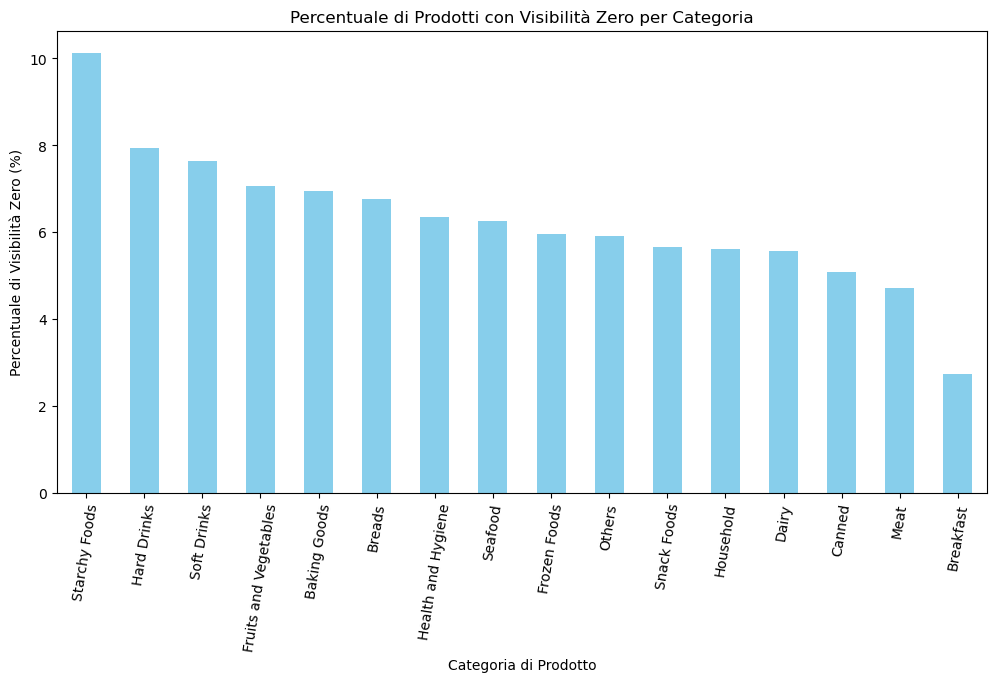

In [23]:
visibility_zero_by_category.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Percentuale di Prodotti con Visibilità Zero per Categoria')
plt.xlabel('Categoria di Prodotto')
plt.ylabel('Percentuale di Visibilità Zero (%)')
plt.xticks(rotation=81)
plt.show()

In [24]:
#faccio la stessa analisi fatta per le categorie ma per i prodotti
products_visibility_zero = df[df['ProductVisibility'] == 0]
product_zero_counts = products_visibility_zero['ProductID'].value_counts()
print(product_zero_counts)

ProductID
FDY07    4
NCD19    3
NCQ05    3
NCK54    3
FDY55    3
        ..
FDA39    1
FDR44    1
NCZ54    1
FDL58    1
FDR47    1
Name: count, Length: 446, dtype: int64


In [25]:
filtered_product_zero_counts = product_zero_counts[product_zero_counts >= 3]
print(filtered_product_zero_counts)

ProductID
FDY07    4
NCD19    3
NCQ05    3
NCK54    3
FDY55    3
FDH48    3
NCK29    3
Name: count, dtype: int64


In [26]:
#questi prodotti appartengono a diverse categorie e non è sistematica la loro esclusione dalla vetrina 
#pertanto assumiamo che i prodotti con visibilità 0 siano tenuti in magazzino e non ne modifichiamo il valore

## Ricerca duplicati, errori nei dati e creazione di nuove feature

In [27]:
#ricerca di duplicati
df.duplicated().sum()

np.int64(0)

In [28]:
#CREAZIONE DI FEATURE UTILI PER L'ANALISI

#fasce di prezzo
df['PriceBand'] = pd.qcut(df['MRP'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

# EUS (EstimatedUnitsSold), proxy di volume basata su fatturato e prezzo di listino
df["EstimatedUnitsSold"]=(df["OutletSales"]/df["MRP"]).round(2)

#età del punto vendita
df['OutletAge'] = 2025 - df['EstablishmentYear']

In [29]:
# OutletSales è una misura di fatturato in unità monetarie non specificate 
# L’analisi si concentra su confronti relativi e pattern interni

In [30]:
#arrotondo i valori di prezzo di vendita e ricavo di periodo alla seconda cifra decimale, in linea con le pratiche finance
df['MRP'] = df['MRP'].round(2)
df['OutletSales'] = df['OutletSales'].round(2)

In [31]:
df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales,VisibilityZero,PriceBand,EstimatedUnitsSold,OutletAge
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14,False,High,14.95,26
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42,False,Low,9.19,16
2,FDN15,17.50,Low Fat,0.016760,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27,False,Mid-Low,14.81,26
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.10,OUT010,1998,Small,Tier 3,Grocery Store,732.38,True,Mid-High,4.02,27
4,NCD19,8.93,Low Fat,0.000000,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71,True,Low,18.47,38


In [32]:
# definisco un range per gli MRP di prodotto tra diversi store, alla ricerca di eventuali errori nel dato
mrp_stats = (df.groupby('ProductID')['MRP'].agg(['min', 'max', 'mean', 'std']))

mrp_stats['range'] = mrp_stats['max'] - mrp_stats['min']

In [33]:
mrp_stats.sort_values('range', ascending=False).head(10)

,min,max,mean,std,range
ProductID,,,,,
FDG33,169.78,173.78,172.300000,1.435889,4.0
FDH27,141.81,145.81,143.485000,1.625467,4.0
FDH40,79.23,83.23,80.946667,1.677399,4.0
FDH60,194.41,198.41,196.793333,1.485149,4.0
NCQ50,211.72,215.72,213.670000,1.661024,4.0
FDR37,180.43,184.43,182.458571,1.398469,4.0
FDZ32,103.20,107.20,105.200000,1.947648,4.0
FDU23,163.12,167.12,164.720000,1.350132,4.0
FDX57,95.21,99.21,96.760000,1.379493,4.0


In [34]:
#la differenza massima di prezzo è di 4€ non sembra un valore grande, ora lo rapportiamo con l'MRP medio
mrp_stats['relative_variation'] = mrp_stats['range'] / mrp_stats['mean']

In [35]:
#definisco un livello del rapporto sopra il quale vado a verificare manualmente per eventuali anomalie di prezzo
mrp_anomalies = mrp_stats[mrp_stats['relative_variation'] > 0.1]

In [36]:
print(mrp_anomalies)

             min    max       mean       std  range  relative_variation
ProductID                                                              
DRN35      34.25  37.95  36.366667  1.463443    3.7            0.101742
FDE59      34.05  37.95  35.366667  1.566418    3.9            0.110273
FDS40      34.62  38.42  36.748571  1.434938    3.8            0.103405
FDX10      33.29  37.19  35.465000  1.931105    3.9            0.109968
FDX59      31.96  35.36  33.660000  1.326650    3.4            0.101010
NCN53      33.29  37.09  35.004286  1.494912    3.8            0.108558
NCO06      32.46  35.96  34.276667  1.387684    3.5            0.102110
NCY05      33.39  37.09  35.430000  1.505988    3.7            0.104431
NCY41      34.05  37.65  35.492857  1.347661    3.6            0.101429


In [37]:
#rilevate differenze di prezzo massime per valori intorno al 10%, le ritengo coerenti e mantengo gli MRP originali
# TERMINATO IL PRE-PROCESSING